# HOTEL BOOKINGS CANCELLATION PREDICTION <a class='tocSkip'>

Hi, in this notebook we'll be using [Hotel Booking Demand](https://www.kaggle.com/jessemostipak/hotel-booking-demand) data from Kaggle. This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things. We are going to visualize the data by using `plotly` and also predict the possibility of hotel bookings using random forest model using `sklearn`.

# Import Libraries
As usual, before we begin any analysis and modeling, let's import several necessary libraries to work with the data. There are two additional packages used in this notebook:
- `pycountry`: contains mapping of ISO country, subdivision, language, currency and script definitions and their translations
- `ppscore`: implementation of the Predictive Power Score (PPS)

In [296]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Interactive Plotting
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.utils import resample
import multiprocessing
import pickle

# Additional Packages
import pycountry
import pycountry_convert as pc
import ppscore as pps

from tqdm.notebook import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

# Data Wrangling
Before we jump into any visualization or modeling step, we have to make sure our data is ready.

## Import Data
Load the downloaded csv and inspect the structure of the data.

In [297]:
hotel = pd.read_csv("dataset/hotel_bookings.csv")
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [298]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Our dataframe `hotel` contains 119390 rows of bookings and 32 columns with data description as follows:
- `hotel`: Hotel (H1 = Resort Hotel or H2 = City Hotel)
- `is_canceled`: Value indicating if the booking was canceled (1) or not (0)
- `lead_time`: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- `arrival_date_year`: Year of arrival date
- `arrival_date_month`: Month of arrival date
- `arrival_date_week_number`: Week number of year for arrival date
- `arrival_date_day_of_month`: Day of arrival date
- `stays_in_weekend_nights`: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- `stays_in_week_nights`: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- `adults`: Number of adults
- `children`: Number of children
- `babies`: Number of babies
- `meal`: Type of meal booked. Categories are presented in standard hospitality meal packages: 
    - Undefined/SC – no meal package;
    - BB – Bed & Breakfast;
    - HB – Half board (breakfast and one other meal – usually dinner); 
    - FB – Full board (breakfast, lunch and dinner)
- `country`: Country of origin. Categories are represented in the ISO 3155–3:2013 format
- `market_segment`: Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- `distribution_channel`: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- `is_repeated_guest`: Value indicating if the booking name was from a repeated guest (1) or not (0)
- `previous_cancellations`: Number of previous bookings that were cancelled by the customer prior to the current booking
- `previous_bookings_not_canceled`: Number of previous bookings not cancelled by the customer prior to the current booking
- `reserved_room_type`: Code of room type reserved. Code is presented instead of designation for anonymity reasons.
- `assigned_room_type`: Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.
- `booking_changes`: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
- `deposit_type`: Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: 
    - No Deposit – no deposit was made; 
    - Non Refund – a deposit was made in the value of the total stay cost; 
    - Refundable – a deposit was made with a value under the total cost of stay.
- `agent`: ID of the travel agency that made the booking
- `company`: ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
- `days_in_waiting_list`: Number of days the booking was in the waiting list before it was confirmed to the customer
- `customer_type`: Type of booking, assuming one of four categories:
    - Contract - when the booking has an allotment or other type of contract associated to it;
    - Group – when the booking is associated to a group; 
    - Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; 
    - Transient-party – when the booking is transient, but is associated to at least other transient booking
- `adr`: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
- `required_car_parking_spaces`: Number of car parking spaces required by the customer
- `total_of_special_requests`: Number of special requests made by the customer (e.g. twin bed or high floor)
- `reservation_status`: Reservation last status, assuming one of three categories:
    - Canceled – booking was canceled by the customer; 
    - Check-Out – customer has checked in but already departed; 
    - No-Show – customer did not check-in and did inform the hotel of the reason why
- `reservation_status_date`: Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel.

## Missing Values
Check if there are any missing values in `hotel`

In [299]:
hotel.isna().sum().sort_values(ascending = False)

company                           112593
agent                              16340
country                              488
children                               4
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
is_canceled                            0
market_segment                         0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
babies                                 0
meal                                   0
reservation_status_date                0
distribution_channel                   0
reservation_status                     0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes 

There are four columns with missing values, here's how we handle them:
- Drop columns `agent` and `company`, since the missing values are too many and we won't use them for prediction
- Create "UNKNOWN" category for `country`
- Fill `children` with the value 0

In [300]:
hotel.drop(columns = ['agent', 'company'], inplace = True)
hotel['country'].fillna("UNKNOWN", inplace = True)
hotel['children'].fillna(0, inplace = True)

Check whether there is another missing values.

In [301]:
hotel.isna().values.any()

False

## Data Type Conversion

### Categorical
We convert object to category data types to save memory. Also map the boolean columns `is_canceled` and `is_repeated_guest` into category for readability.

In [302]:
category_cols = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']
boolean_cols = ['is_canceled', 'is_repeated_guest']

boolean_map = {0: 'No', 1: 'Yes'}

hotel['is_canceled'] = hotel['is_canceled'].map(boolean_map)
hotel['is_repeated_guest'] = hotel['is_repeated_guest'].map(boolean_map)

hotel[category_cols + boolean_cols] = hotel[category_cols + boolean_cols].astype('category')
hotel['is_canceled'].cat.reorder_categories(list(boolean_map.values()), inplace = True)
hotel['is_repeated_guest'].cat.reorder_categories(list(boolean_map.values()), inplace = True)


### Numerical
Convert `children` from float to integer.

In [303]:
hotel['children'].apply(float.is_integer).all()
hotel['children'] = hotel['children'].astype('int')

### Datetime
Convert `reservation_status_date` as datetime.

In [304]:
hotel['reservation_status_date'] = hotel['reservation_status_date'].astype('datetime64')

Here's the final data types of `hotel`:

In [305]:
hotel.dtypes

hotel                                   category
is_canceled                             category
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                   int32
babies                                     int64
meal                                    category
country                                 category
market_segment                          category
distribution_channel                    category
is_repeated_guest                       category
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                      category
assigned_room_type  

## Feature Engineering
Feature engineering is the process of using domain knowledge to extract features from provided raw data. These features can be used to improve the performance of machine learning models.

## Room Type Assignment
Instead of considering each assigned and reserved room type, we create a new column `is_assigned_as_reserved` to make a flag whether the customer get their expected room type or not.

In [306]:
hotel['reserved_room_type'].cat.set_categories(hotel['assigned_room_type'].cat.categories, inplace = True)
hotel['is_assigned_as_reserved'] = (hotel['assigned_room_type'] == hotel['reserved_room_type']).astype('category')
hotel['is_assigned_as_reserved']

0          True
1          True
2         False
3          True
4          True
          ...  
119385     True
119386     True
119387     True
119388     True
119389     True
Name: is_assigned_as_reserved, Length: 119390, dtype: category
Categories (2, object): [False, True]

### Arrival Date
Combine `arrival_date_year`, `arrival_date_month`, `arrival_date_day_of_month` into one column `arrival_date` so that we can extract more information from the date.

In [307]:
arrival_date_cols = ['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']
hotel[arrival_date_cols] = hotel[arrival_date_cols].astype(str)
hotel['arrival_date'] = pd.to_datetime(hotel[arrival_date_cols].apply('-'.join, axis = 1), format = "%Y-%B-%d")
hotel.drop(columns = arrival_date_cols + ['arrival_date_week_number'], inplace = True)

### Booking Date
Create `booking_date` by subtracting `lead_time` days from `arrival_date`.

In [308]:
hotel['booking_date'] = hotel['arrival_date'] - pd.to_timedelta(hotel['lead_time'], unit = 'days')
hotel[['booking_date', 'arrival_date', 'lead_time']].head()

,booking_date,arrival_date,lead_time
0,2014-07-24,2015-07-01,342
1,2013-06-24,2015-07-01,737
2,2015-06-24,2015-07-01,7
3,2015-06-18,2015-07-01,13
4,2015-06-17,2015-07-01,14


### Country and Continent Name
The column `country` represents code of a country in the ISO 3155–3:2013 format. By utilizing the code-to-name mapping provided in `pycountry` package, we can extract it into `country_name` and `continent_name`.

In [309]:
additional_code2name = {'TMP': 'East Timor'}

def convertCountryCode2Name(code):
    country_name = None
    try:
        if len(code) == 2:
            country_name = pycountry.countries.get(alpha_2 = code).name
        elif len(code) == 3:
            country_name = pycountry.countries.get(alpha_3 = code).name
    except:
        if code in additional_code2name.keys():
            country_name = additional_code2name[code]
    return country_name if country_name is not None else code
    
hotel['country_name'] = hotel['country'].apply(convertCountryCode2Name).astype('category')
hotel['country_name'].head()

0          Portugal
1          Portugal
2    United Kingdom
3    United Kingdom
4    United Kingdom
Name: country_name, dtype: category
Categories (177, object): [Albania, Algeria, American Samoa, Andorra, ..., Viet Nam, Virgin Islands, British, Zambia, Zimbabwe]

In [310]:
additional_name2continent = {'East Timor': 'Asia', 'United States Minor Outlying Islands': 'North America', 'French Southern Territories': 'Antarctica', 'Antarctica': 'Antarctica'}

def convertCountryName2Continent(country_name):
    continent_name = None
    try:
        alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    except:
        if country_name in additional_name2continent.keys():
            continent_name = additional_name2continent[country_name]
        else:
            continent_name = "UNKNOWN"
    return continent_name if continent_name is not None else country_name

hotel['continent_name'] = hotel['country_name'].apply(convertCountryName2Continent).astype('category')
hotel['continent_name'].head()

0    Europe
1    Europe
2    Europe
3    Europe
4    Europe
Name: continent_name, dtype: category
Categories (8, object): [Africa, Antarctica, Asia, Europe, North America, Oceania, South America, UNKNOWN]

## Suspicious Bookings
There are some hidden anomalies present in the hotel bookings. Let's create new variables and plot their frequencies:
- `total_guest`: Total number of `adults`, `children`, and `babies`
- `total_nights`: Number of nights the guest stayed at the hotel, sum of `stays_in_weekend_nights` and `stays_in_week_nights`

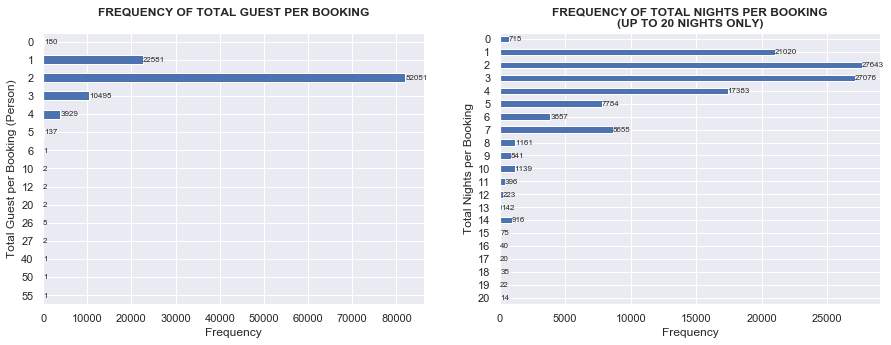

In [311]:
hotel['total_guest'] = hotel[['adults', 'children', 'babies']].sum(axis = 1)
hotel['total_nights'] = hotel[['stays_in_weekend_nights', 'stays_in_week_nights']].sum(axis = 1)

data2plot = [hotel['total_guest'].value_counts().sort_index(ascending = False),
             hotel['total_nights'].value_counts().sort_index(ascending = False)[-21:]]

ylabs = ["Total Guest per Booking (Person)", "Total Nights per Booking"]
titles = ["FREQUENCY OF TOTAL GUEST PER BOOKING\n", "FREQUENCY OF TOTAL NIGHTS PER BOOKING\n(UP TO 20 NIGHTS ONLY)"]

fig, axes = plt.subplots(1, 2, figsize = (15, 5))
for ax, data, ylab, title in zip(axes, data2plot, ylabs, titles):
    bp = data.plot(kind = 'barh', rot = 0, ax = ax)
    for rect in bp.patches:
        height = rect.get_height()
        width = rect.get_width()
        bp.text(rect.get_x() + width, 
                rect.get_y() + height/2, 
                int(width), 
                ha = 'left',
                va = 'center',
                fontsize = 8)
    bp.set_xlabel("Frequency")
    bp.set_ylabel(ylab)
    ax.set_title(title, fontweight = "bold")

There are 180 bookings without guest (`total_guest` = 0) and 715 bookings with zero nights of staying at the hotel (`total_nights` = 0). Ideally, such cases should not occur on our bookings data. Therefore, from this point onwards we will ignore the observations with either cases since it can affect our modeling outcome.

In [312]:
hotel = hotel[(hotel['total_guest'] != 0) & (hotel['total_nights'] != 0)]
hotel.shape

(118565, 33)

We end up with 118565 rows of bookings, originally it was 119390 rows.

# Exploratory Data Analysis (EDA)
Before we jump into the modeling step, it is recommended to visualize the data to better understand our data.

## How is the proportion of booking cancellation based on reservation status?

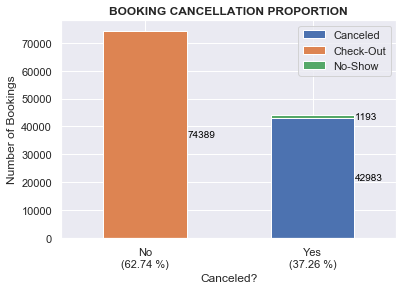

In [313]:
df_cancel_status = pd.crosstab(index = hotel.is_canceled,
                               columns = hotel.reservation_status,
                               margins = True)

ax = df_cancel_status.iloc[:-1,:-1].plot(kind = 'bar', stacked = True, rot = 0)
for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    if height != 0:
        ax.text(rect.get_x() + width, 
                rect.get_y() + height/2, 
                int(height), 
                ha = 'left',
                va = 'center',
                color = "black",
                fontsize = 10)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)

percent_no = (100*df_cancel_status/df_cancel_status.iloc[-1,-1]).loc["No", "All"]
ax.set_xticklabels(["No\n({:.2f} %)".format(percent_no), "Yes\n({:.2f} %)".format(100-percent_no)])
ax.set_xlabel("Canceled?")
ax.set_ylabel("Number of Bookings")
plt.title("BOOKING CANCELLATION PROPORTION", fontweight = "bold")
plt.show()

The proportion of the target variable `is_canceled` is somewhat balanced. There is 37.26% of the bookings which are canceled, divided into two cases:
- Canceled: Booking was canceled by the customer, or
- No-show: Customer did not check-in and did inform the hotel of the reason why.

## Where do most bookings happens?

In [314]:
df_choropleth = hotel.copy()
df_choropleth['booking_date_year'] = df_choropleth['booking_date'].dt.year
df_country_year_count = df_choropleth.groupby(['country', 'booking_date_year']).count()['hotel'].fillna(0).reset_index() \
                        .rename(columns={'country': 'country_code', 'booking_date_year': 'year', 'hotel':'count'})
df_country_year_count['country_name'] = df_country_year_count['country_code'].apply(convertCountryCode2Name)
df_country_year_count['count'] = df_country_year_count['count'].astype('int')

fig = px.choropleth(df_country_year_count[df_country_year_count["year"] != 2013], 
                    locations = "country_code", color = "count", animation_frame = "year",
                    hover_name = "country_name", 
                    range_color = (0, 5000),
                    color_continuous_scale = px.colors.sequential.Reds,
                    projection = "natural earth")
fig.update_layout(title = 'ANNUAL HOTEL BOOKING COUNTS',
                  template = "seaborn")

fig.show()

From the choropleth map we can see throughout the year, Europe is the continent with the most hotel booking counts. The specific country with the most bookings is Portugal (PRT).

## Which continent has the greatest cancellation rate?
From the previous section, we know Europe is the continent with most bookings, but how about the cancellation rate?

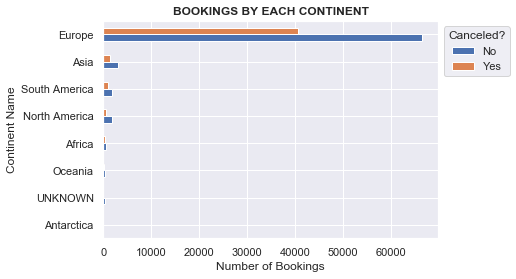

In [315]:
ax = pd.crosstab(index = hotel['continent_name'],
                 columns = hotel['is_canceled'],
                 margins = True).sort_values('All').iloc[:-1,:-1].plot(kind = 'barh')
ax.legend(bbox_to_anchor = (1, 1), title = "Canceled?")
ax.set_xlabel("Number of Bookings")
ax.set_ylabel("Continent Name")
ax.set_title("BOOKINGS BY EACH CONTINENT", fontweight = "bold")
plt.show()

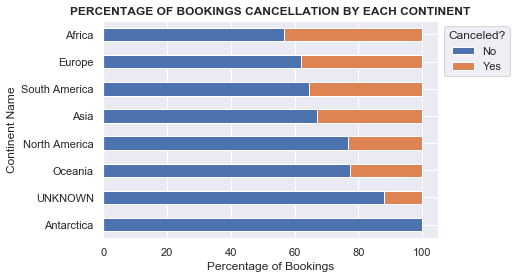

In [316]:
ax = (pd.crosstab(index = hotel['continent_name'],
                  columns = hotel['is_canceled'],
                  normalize = 'index').sort_values('Yes') * 100).plot(kind = 'barh', stacked = True)
ax.legend(bbox_to_anchor = (1, 1), title = "Canceled?")
ax.set_xlabel("Percentage of Bookings")
ax.set_ylabel("Continent Name")
ax.set_title("PERCENTAGE OF BOOKINGS CANCELLATION BY EACH CONTINENT", fontweight = "bold")
plt.show()

It turns out that Africa has the greatest cancellation rate amongst the other continent.

## How is the cancellation rate over time?

In [317]:
df_cancellation = hotel.copy()
df_cancellation['date_period'] = df_cancellation['reservation_status_date'].dt.to_period('M')
df_cancellation_percent = df_cancellation.groupby(['date_period', 'is_canceled', 'hotel'])['hotel'].count() \
                            .groupby(['date_period', 'hotel']).apply(lambda x: 100*x/x.sum()) \
                            .unstack(level = 'is_canceled') \
                            .rename(columns = str).reset_index().rename_axis(None, axis = 1).rename(columns = {'hotel': 'Hotel Type'})
df_cancellation_percent['date_period'] = df_cancellation_percent['date_period'].values.astype('datetime64[M]')

fig = px.line(df_cancellation_percent, x = 'date_period', y = 'Yes', color = 'Hotel Type')
fig.update_traces(mode = "markers+lines",
                  hovertemplate = "Rate: %{y:.2f}%")
fig.update_layout(title = 'CANCELLATION RATE OVER TIME BY HOTEL TYPE',
                  xaxis_title = 'Cancellation Period',
                  yaxis_title = 'Cancellation Rate (%)',
                  hovermode = 'x',
                  template = "seaborn",
                  xaxis = dict(tickformat="%b %Y"))
fig.show()

Most of the time, City hotel has greater cancellation rate than Resort hotel. The good news is that: both rate are decreasing towards zero during mid 2017, meaning none of the booking was cancelled. But we have to anticipate during the beginning of year 2018, since for the past three years there are peaks on the cancellation rate during January. Therefore in the next section, we can use a Machine Learning model to predict whether certain bookings will be canceled by the customer or not from predictor variables present in our data.

# Predictive Power Score (PPS)
According to [Florian Wetschoreck](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598), PPS is an asymmetric and data-type-agnostic score that can detect linear or non-linear relationships between two columns. One column acts as an univariate predictor, whereas the other acts as the target variable. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation matrix.

The PPS is calculated as follows:

$PPS = \dfrac{F1_{model} - F1_{naive}}{1 - F1_{naive}}$

where:
- $F1_{naive}$ is the weighted F1 score of a naive model that always predicts the most common class of the target column.
- $F1_{model}$ is the weighted F1 score of a classifier using `sklearn.DecisionTreeClassifier`.

Detailed explanation is available [here](https://github.com/8080labs/ppscore).

Before we investigate the PPS, we do the following:
- Consider dayofyear instead of datetime for `booking_date`, `reservation_status_date`, and `arrival_date`.
- Ignore `assigned_room_type` and `reserved_room_type` because the levels are quite many, instead `is_assigned_as_reserved` will be considered.
- Ignore `country` and `country_name` because the levels are too many, instead `continent_name` will be considered.
- Convert the categorical columns into dummy variables.

In [318]:
datetime_cols = ['booking_date', 'reservation_status_date', 'arrival_date']
for col in datetime_cols:
    hotel[f"{col}_dayofyear"] = hotel[col].dt.dayofyear

ignore_cols = ['assigned_room_type', 'reserved_room_type', 'country', 'country_name']
hotel_pps_data = hotel.drop(datetime_cols + ignore_cols, axis = 1)

hotel_pps_dummy = pd.get_dummies(hotel_pps_data)
hotel_pps_dummy.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,is_assigned_as_reserved_False,is_assigned_as_reserved_True,continent_name_Africa,continent_name_Antarctica,continent_name_Asia,continent_name_Europe,continent_name_North America,continent_name_Oceania,continent_name_South America,continent_name_UNKNOWN
2,7,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,13,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,14,0,2,2,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
5,14,0,2,2,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
6,0,0,2,2,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


We treat each columns of `hotel_pps_dummy` as a univariate predictors of `is_canceled`, then calculate the PPS and present the result in the form of DataFrame.

In [319]:
pps_score = []
target = 'is_canceled_Yes'
for col in hotel_pps_dummy.columns:
    if col == target:
        continue
    d = {}
    d['feature'] = col
    d['dtypes'] = 'categorical' if hotel_pps_dummy[col].dtypes == 'uint8' else 'numerical'
    d['pps'] = pps.score(hotel_pps_dummy, x = col, y = target, task = 'classification')['ppscore']
    pps_score.append(d)
    
hotel_pps = pd.DataFrame(pps_score).set_index('feature')
hotel_pps.head()

,dtypes,pps
feature,,
lead_time,numerical,2.863298e-01
stays_in_weekend_nights,numerical,1.427558e-03
stays_in_week_nights,numerical,6.617232e-03
adults,numerical,0.000000e+00
children,numerical,1.081417e-07


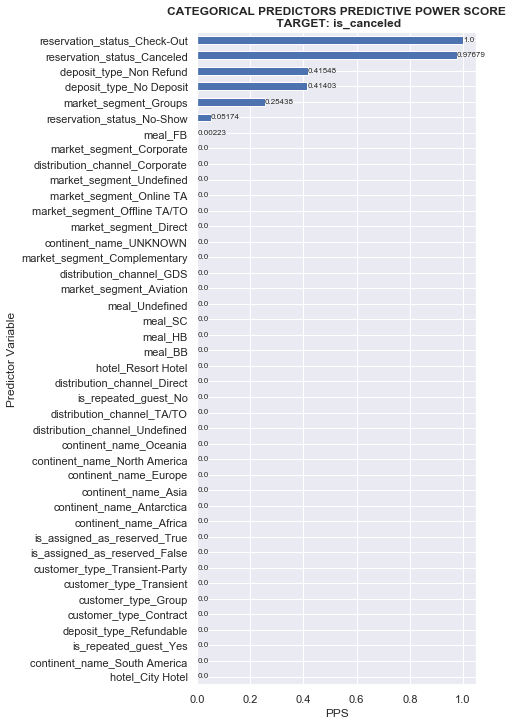

In [320]:
ax = hotel_pps[hotel_pps['dtypes'] == 'categorical'].sort_values('pps')[:-1]\
        .plot(kind = 'barh', legend = False, figsize = (5, 12))
for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    ax.text(rect.get_x() + width, 
            rect.get_y() + height, 
            round(width, 5), 
            ha = 'left',
            va = 'top',
            fontsize = 8)
ax.set_xlabel("PPS")
ax.set_ylabel("Predictor Variable")
plt.title("CATEGORICAL PREDICTORS PREDICTIVE POWER SCORE\n TARGET: is_canceled", fontweight = "bold")
plt.show()

From PPS of the categorical variables, we have to ignore `reservation_status` for the modeling. The score is high because from the business perspective, this value is actually `is_canceled` but breakdown into three specific categories. So we cannot use this as a predictor.

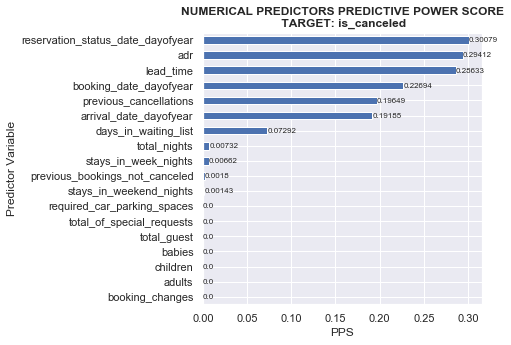

In [321]:
ax = hotel_pps[hotel_pps['dtypes'] == 'numerical'].sort_values('pps')\
        .plot(kind = 'barh', legend = False, figsize = (5, 5))
for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    ax.text(rect.get_x() + width, 
            rect.get_y() + height/2, 
            round(width, 5), 
            ha = 'left',
            va = 'center',
            fontsize = 8)
ax.set_xlabel("PPS")
ax.set_ylabel("Predictor Variable")
plt.title("NUMERICAL PREDICTORS PREDICTIVE POWER SCORE\n TARGET: is_canceled", fontweight = "bold")
plt.show()

From PPS of the numerical variables, we have ignore `reservation_status_date_dayofyear` the reason is the same as before when we ignore `reservation_status`. We can ignore `stay_in_week_nights` and `stay_in_weekend_nights` because already explained by `total_nights`. Also, `adults`, `children`, and `babies` are explained by `total_guest`.

# Modeling and Evaluation
Now, let's proceed to the modeling step using Random Forest Classifier by `sklearn`.

## Feature Selection
PPS score from the previous section help us to identify which column to be ignored. We are going to drop four columns before we fit the data into Random Forest model.

In [322]:
ignore_cols_for_model = ['reservation_status', 'reservation_status_date_dayofyear',
                         'total_nights', 'total_guest']
hotel_model = hotel_pps_data.drop(columns = ignore_cols_for_model)

## Balancing Data
Our target variable proportion has 63:37 ratio. We can do either upsampling or downsampling to balance the positive and negative class of `is_canceled` into 50:50 ratio.

- Upsampling is a method to randomly subsample the observation from minority class to make the dataset balanced.
- Downsampling is a method to randomly sample (with replacement) the observation from majority class to make the dataset balanced.

In this case we prefer to do downsampling the data since we have thousands of observations, which sufficient for modeling.

In [323]:
def sampleData(data, target_col, method = "down"):
  freq = data[target_col].value_counts()
  class_majority, class_minority = freq.idxmax(), freq.idxmin()
  data_majority, data_minority = data[data[target_col] == class_majority], data[data[target_col] == class_minority]
  if method == "down":
    data_hold = data_minority
    data_sample = data_majority
    replacement = False
  elif method == "up":
    data_hold = data_majority
    data_sample = data_minority
    replacement = True

  data_sampled = resample(data_sample,
                          n_samples = data_hold.shape[0],
                          replace = replacement,
                          random_state = 333)
  return pd.concat([data_sampled, data_hold])

hotel_model_sampled = sampleData(hotel_model, "is_canceled", "down")
print(f'Before sampling: {hotel_model.shape}')
print(f'After samping: {hotel_model_sampled.shape}')

Before sampling: (118565, 25)
After samping: (88352, 25)


## Train-test split
We split our dataset into 80% train and 20% test dataset for model evaluation.

In [324]:
hotel_model_dummy = pd.get_dummies(hotel_model_sampled, drop_first = True)
X = hotel_model_dummy.drop(['is_canceled_Yes'], axis = 1)
y = hotel_model_dummy['is_canceled_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, shuffle = True, random_state = 333)

## Default Model
First, we fit the train dataset into `RandomForestClassifier` without tuning any parameter to know the starting performance of our model as a benchmark.

In [325]:
model_default = RandomForestClassifier(n_jobs = multiprocessing.cpu_count()-1, oob_score = True, random_state = 333, verbose = 1)
model_default.fit(X_train, y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    1.3s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    3.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=7,
                       oob_score=True, random_state=333, verbose=1,
                       warm_start=False)

Then we evaluate the `model_default` by printing out classification metrics such as:
- **Accuracy**: the proportion of observations that are classified correctly.
- **Recall**: the proportion of actual positives that are classified correctly.
- **Precision**: the proportion of True Positives out of all observations predicted as positive.
- **F1-score**: the harmonic mean of precision and recall.

Additional:
- **Observation**: number of observations that are being considered during evaluation.
- **pos_proportion**: percentage of positive class relative to total observations. We expect this to be somewhat near the original target class ratio before train-test split.

In [326]:
def clfReport(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict = True,
                                  target_names = ["Not Canceled", "Canceled"])
    return pd.DataFrame(report).transpose()

def trainTestEval(model, pos_class, X_train, X_test, y_train, y_test):
    report_train = clfReport(y_train, model.predict(X_train))
    report_test = clfReport(y_test, model.predict(X_test))
    df = pd.concat([report_train.loc[pos_class, :].rename("Train"),
                     report_test.loc[pos_class, :].rename("Test")], axis = 1).transpose()
    df.insert(loc = 0, column = "accuracy",
              value = [report_train.loc["accuracy", "support"],
                       report_test.loc["accuracy", "support"]])
    df["observation"] = np.array([X_train.shape[0], X_test.shape[0]])
    df["pos_proportion"] = df["support"]/df["observation"]
    return df.drop(columns = "support")

In [327]:
trainTestEval(model_default, "Canceled", X_train, X_test, y_train, y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


,accuracy,precision,recall,f1-score,observation,pos_proportion
Train,0.992388,0.993075,0.991667,0.992371,70681,0.499186
Test,0.854847,0.873113,0.832565,0.852357,17671,0.503254


From the evaluation report above, we can conclude that `model_default` is overfitted the data, since the performance on the training dataset is nearly perfect (all metrics reach 99%) but not so good on the test dataset (around 83-87%). To overcome this, in the next section, we are going to use Random Search Cross-Validation which is one technique to do hyperparameter tuning.

## Random Search Cross-Validation
This technique narrows down our search by evaluating a wide range of values for each parameter. Using the `sklearn` RandomizedSearchCV method, we define a grid of hyperparameter ranges `random_grid` and as the name suggests, it randomly samples from the grid, performing k-fold cross-validation with each combination of values.

In [57]:
random_grid = {
    'n_estimators': [x for x in range(50, 1000, 50)],
    'criterion': ['gini', 'entropy'],
    'max_depth': [x for x in range(10, 100, 5)],
    'min_samples_split': [x for x in range(10, 50, 5)],
    'min_samples_leaf': [x for x in range(10, 50, 5)],
    'max_features': ['sqrt', 'log2', None]
    }

# number of possible combinations
mul = 1
for key in random_grid.keys():
    mul *= len(random_grid[key])
mul

131328

There are 131,328 possible combinations of the parameter from `random_grid`, we decided to build models by using only 500 combinations. Using 3-fold cross-validation means that each combination of parameters will be evaluated 3 times with a 67-33 train-test proportion. The scoring uses "recall" because in this case, we want to minimize False Negative, where a canceled booking is predicted as not canceled. Suppose the marketing team of this hotel only offers follow-up promotions to customers who are predicted as canceled. If the recall is too low, then the potential customer who will cancel their booking won't be contacted. Anyway, the Random Search process takes a while, around 5-6 hours to be specific, since we train them on CPU - maybe should consider using GPU.

In [58]:
model_base = RandomForestClassifier(oob_score = True,
                                    warm_start = True,
                                    n_jobs = multiprocessing.cpu_count()-1,
                                    random_state = 333)

rf_random = RandomizedSearchCV(estimator = model_base,
                               param_distributions = random_grid,
                               scoring = 'recall',
                               n_iter = 500,
                               cv = 3,
                               verbose = 1,
                               n_jobs = multiprocessing.cpu_count()-1,
                               random_state = 333)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  7.4min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed: 44.0min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 98.1min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 177.5min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 280.4min
[Parallel(n_jobs=7)]: Done 1500 out of 1500 | elapsed: 338.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

We save the Random Search result to pickle.

In [59]:
def saveModel(model, pickle_name):
    with open(pickle_name, 'wb') as f:
        pickle.dump(model, f)
        
saveModel(rf_random, "rf_random_500.pkl")

Let's take a look of the result from best to worst in terms of Recall and print one combination of the parameter which yield the best recall.

In [60]:
pd.DataFrame(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
293,116.845358,8.798185,4.030559,0.143989,350,20,10,None,60,entropy,"{'n_estimators': 350, 'min_samples_split': 20,...",0.812516,0.822804,0.809880,0.815067,0.005576,1
233,210.785940,1.999575,2.502307,0.796225,500,15,10,None,90,entropy,"{'n_estimators': 500, 'min_samples_split': 15,...",0.813876,0.821869,0.809200,0.814982,0.005231,2
393,203.311912,0.463509,4.587406,0.073421,550,20,10,None,85,entropy,"{'n_estimators': 550, 'min_samples_split': 20,...",0.813451,0.822379,0.809030,0.814953,0.005552,3
426,102.950496,6.532185,4.649240,1.026608,250,20,10,None,25,entropy,"{'n_estimators': 250, 'min_samples_split': 20,...",0.813791,0.822464,0.808010,0.814755,0.005940,4
31,152.967862,39.159044,5.434141,1.207670,350,15,10,None,80,entropy,"{'n_estimators': 350, 'min_samples_split': 15,...",0.812941,0.821529,0.808775,0.814415,0.005310,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,45.979438,7.434422,4.246983,1.078517,600,45,30,sqrt,10,entropy,"{'n_estimators': 600, 'min_samples_split': 45,...",0.705127,0.722388,0.711844,0.713120,0.007104,496
431,80.721575,2.528962,3.691467,1.187596,950,10,45,log2,10,gini,"{'n_estimators': 950, 'min_samples_split': 10,...",0.708528,0.712269,0.707423,0.709407,0.002074,497
37,21.343951,0.361174,1.525256,0.819684,350,10,45,log2,10,gini,"{'n_estimators': 350, 'min_samples_split': 10,...",0.710909,0.699345,0.703001,0.704419,0.004826,498
189,73.306065,9.221480,3.005634,0.744539,900,25,35,log2,10,entropy,"{'n_estimators': 900, 'min_samples_split': 25,...",0.696284,0.707763,0.707763,0.703937,0.005411,499


In [61]:
rf_random.best_params_

{'n_estimators': 350,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_features': None,
 'max_depth': 60,
 'criterion': 'entropy'}

Next, we fit RandomForestClassifier using the best parameters.

In [328]:
model_tuned = RandomForestClassifier(**rf_random.best_params_, verbose = 1,
                                     n_jobs = multiprocessing.cpu_count()-1, random_state = 333)
model_tuned.fit(X_train, y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    5.3s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   21.1s
[Parallel(n_jobs=7)]: Done 350 out of 350 | elapsed:   38.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=60, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=7,
                       oob_score=False, random_state=333, verbose=1,
                       warm_start=False)

Just like we did on `model_default`, let's evaluate whether our model is still overfit or not:

In [329]:
model_tuned_metrics = trainTestEval(model_tuned, "Canceled", X_train, X_test, y_train, y_test)
model_tuned_metrics

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 350 out of 350 | elapsed:    1.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 350 out of 350 | elapsed:    0.1s finished


,accuracy,precision,recall,f1-score,observation,pos_proportion
Train,0.896280,0.909181,0.880141,0.894425,70681,0.499186
Test,0.841831,0.858959,0.820421,0.839248,17671,0.503254


It turns out that `model_tuned` is not too overfitted compare to `model_Default`. Considering the difference of recall between train and test is only 6%, before it was a 16% difference.

## Threshold Tuning
We can further tune `model_tuned` by changing the threshold when classifying the probabilities to a class. So far, the model use default threshold which is 0.5, means that if a booking is predicted to have more than 50% chance of cancellation, then it is classified as `Canceled`, otherwise `Not Canceled`. We create `tuningThresholdPlot` function to iteratively move the threshold from 0 to 1 and plot the classification metrics.

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 350 out of 350 | elapsed:    0.2s finished


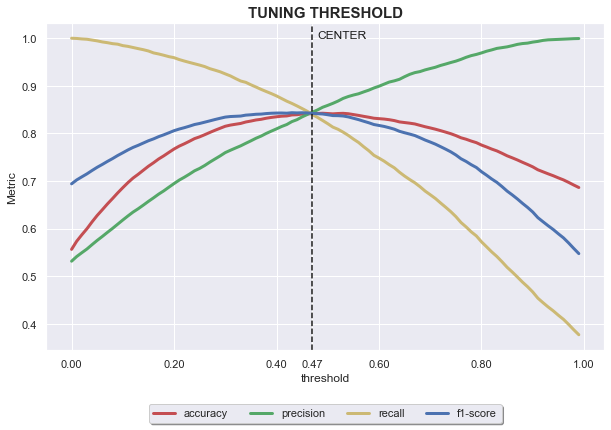

In [330]:
def tuningThresholdPlot(model, X, y):
    tuning_list = []
    y_pred_prob = model.predict_proba(X)[:,1]
    for threshold in np.linspace(0, 1, 101)[:-1]:
        y_pred_class = y_pred_prob > threshold
        report = clfReport(y, y_pred_class)
        tuning_res = {"threshold" : threshold,
                      "accuracy": report.loc["accuracy"][-1]}
        tuning_res = {**tuning_res, **report.loc["Canceled"].to_dict()} # append dicts
        tuning_res.pop("support", None)
        tuning_list.append(tuning_res)
    tuning_df = pd.DataFrame(tuning_list)
    
    # plotting
    ax = tuning_df.plot(x = "threshold", color = "rgyb", lw = 3, figsize = (10, 6))
    
    # vertical line for center
    diff = abs(tuning_df["recall"] - tuning_df["precision"])
    thresh_center = tuning_df[diff == min(diff)]["threshold"].values[0]
    ax.axvline(x = thresh_center, ls = '--', color = "k")
    ax.text(x = thresh_center + 0.01, y = 1,
            s = f"CENTER", fontsize = 12, color = "k")
    
    ax.set_xticks(list(ax.get_xticks()[1:-1]) + [thresh_center])
    ax.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.15), shadow = True, ncol = 4)
    ax.set_ylabel("Metric")
    plt.title("TUNING THRESHOLD", size = 15, fontweight = "bold")
    plt.show()
    
    return tuning_df

tuning_thresh = tuningThresholdPlot(model_tuned, X_test, y_test)

The vertical line labeled "CENTER" is when precision equal to recall. As mentioned earlier, we do care about the recall so we will use threshold less than 0.47 to achieve higher recall. Then on second priority, we have to take into account about the precision too so that our model can correctly classify bookings that are not canceled but predicted as canceled (False Positives). Therefore we try to maximize the F1-score which counts for both recall and precision.

In [331]:
tune_thresh_metrics = tuning_thresh[tuning_thresh["f1-score"] == tuning_thresh["f1-score"].max()]
tune_thresh_metrics

,threshold,accuracy,precision,recall,f1-score
43,0.43,0.838832,0.824825,0.863038,0.843499


Let's calculate gain/loss of the metrics before and after we change the threshold.

In [332]:
tune_thresh_metrics.iloc[0,1:] - model_tuned_metrics.iloc[1,:-2]

accuracy    -0.002999
precision   -0.034134
recall       0.042618
f1-score     0.004252
dtype: float64

In conclusion, we have to set the threshold to be 0.43 to gain 4,2% recall and 0,4% F1 while sacrificing 3,4% precision and 0,3% accuracy.

In [333]:
THRESHOLD = tune_thresh_metrics.iloc[0,0]
THRESHOLD

0.43

## Receiver Operating Characteristic (ROC) Curve
It is a probability curve which plots True Positive Rate (Recall) against False Positive Rate. The area under the ROC curve, called as **Area Under Curve (AUC)**, measures the degree of classification separability. Higher the AUC, better the model is at distinguishing between canceled and not canceled bookings.
- AUC near to 1 indicates the model has good measure of separability.
- AUC near to 0 means it has worst measure of separability.
- When AUC is 0.5, it means model has no class separation capacity whatsoever.

In [334]:
def rocauc(y_pred_list, y_test):
    y_pred_list = [(np.zeros(len(y_test)), "BASELINE")] + y_pred_list
    for y_pred, label in y_pred_list:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        plt.plot(fpr, tpr, label = f"{label}\n(AUC: {auc:.3f})",
                 linestyle = '--' if label == "BASELINE" else '-')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("RECEIVER OPERATING CHARACTERISTIC (ROC) CURVE", fontweight = "bold")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 350 out of 350 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 350 out of 350 | elapsed:    0.2s finished


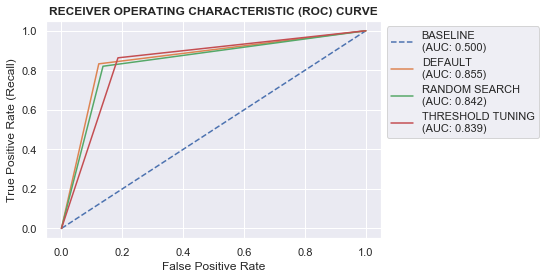

In [335]:
rocauc([(model_default.predict(X_test), "DEFAULT"),
        (model_tuned.predict(X_test), "RANDOM SEARCH"),
        (model_tuned.predict_proba(X_test)[:,1] > THRESHOLD, "THRESHOLD TUNING")], y_test)

The AUC after we tune the threshold is not far different from the earlier one (default or random search), indicating the measure of separability is somewhat the same while we improving the recall.

## Feature Importance
This refers to a technique that assign a score to features based on how useful they are at predicting a target variable. In this case, we want to know which feature is the most important in predicting hotel booking cancellation using `sklearn` built-in attributes `feature_importances_`.

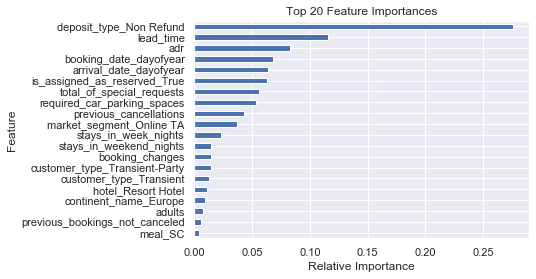

In [336]:
def featureImportancesPlot(features, importances, n_features = 20):
    feature_imp_df = pd.DataFrame({'Feature': features,
                                   'Importance': importances}).set_index('Feature')\
                        .sort_values('Importance').tail(n_features)
    ax = feature_imp_df.plot(kind = 'barh', legend = False,
                             title = f"Top {n_features} Feature Importances")
    ax.set_xlabel("Relative Importance")
    plt.show()
    return feature_imp_df.sort_values('Importance', ascending = False)
    
feature_imp = featureImportancesPlot(X.columns, model_tuned.feature_importances_)

The top three features based on their importance are:
1. `deposit_type_Non Refund`: the customer made a deposit to guarantee the booking in the value of the total stay cost
2. `lead_time`: number of days that elapsed between the entering date of the booking into the PMS and the arrival date
3. `adr`: average daily rate

# Conclusion
We successfully visualized the hotel booking data using `plotly` to gain insights about the data and modeling using Random Forest to predict the cancellation of the booking based on various predictors. Before modeling, we inspect the PPS score to do feature selection manually. Next, we tune the base model using `RandomizedSearchCV` to prevent overfitting, followed by threshold tuning to further improve the recall. In the end, we achieve a quite good recall (86.3%) and F1-score (84.3%). 

There are several things need to be improved:
- Tuning other parameters such as `ccp_alpha` to cut the tree with cost complexity pruning.
- SearchCV using GPU instead of CPU, explore more about `cuML` packages (but for now not available on Windows OS).
- Use another ensemble method such as XGBoost